In [1]:
import os
import cv2
import numpy as np
from os import listdir

import time
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster

%matplotlib inline

In [2]:
matplotlib.rcParams['figure.figsize'] = (20.0, 18.0)

In [3]:
def capture_frames(file_list):
    """function to extract the frames in which the dice are settled 
    after rolling.
    
    imput: list of file names of the videos
    output: list of captured frames
    """
    
    # empty list to store the captured frames from the video
    captured_frames = []

    
    for file in file_list:
        cap = cv2.VideoCapture('./VideoPackage/'+file)
        frameRate = cap.get(5) #frame rate
        n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        fps = cap.get(cv2.CAP_PROP_FPS)

        img_list = []
        while cap.isOpened():
            frameId = cap.get(1) #current frame number
            frame_time = time.time()
            ret, frame = cap.read()
            if (ret != True):
                break
            if (frameId % math.floor(frameRate/2.0) == 0):
                b,g,r = cv2.split(frame)
                img = cv2.merge((b,g,r))
                gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_list.append(gray_image)
        cap.release()

        frame_diff_list = []
        # calculating the frame difference between consecutive frames
        for i in range(1,len(img_list)):
            frame_diff = cv2.absdiff(img_list[i],img_list[i-1])
            frame_diff = cv2.GaussianBlur(frame_diff,(3,3),0)
            frame_diff = cv2.threshold(frame_diff, 25, 255, cv2.THRESH_BINARY)[1]
            frame_diff_list.append(cv2.countNonZero(frame_diff))

        min_idx = np.argmin(frame_diff_list)
        if len(frame_diff_list) > 6 and min_idx > int(len(frame_diff_list)*0.8):
            min_idx = np.argmin(frame_diff_list[:-2])
        # storing the frame with the least consecutive frame difference for further processing
        captured_frames.append(img_list[min_idx+1])
    return captured_frames

def detect_pips_and_locations(captured_frames):
    """ function to detect the pips on the top face
    and location of each die 
    
    input: list of frames
    output: plot of each frame with detected pips and number of pips
    """
    
    for f in captured_frames:
        gray_image = f
        x_range1 = int(gray_image.shape[0]*0.06)
        x_range2 = int(gray_image.shape[0]*0.91)
        y_range1 = int(gray_image.shape[1]*0.05)
        y_range2 = int(gray_image.shape[1]*0.95)

        # cropping out the outer border
        gray_image[:,0:y_range1] = 0.0
        gray_image[:,y_range2:] = 0.0
        gray_image[:x_range1,:] = 0.0
        gray_image[x_range2:,:] = 0.0

        plt.figure(figsize=(20,18))

        # setting the parameters for the blob_detection function of OpenCV
        min_threshold = 50                     
        max_threshold = 200                     
        min_area = 100                          
        max_area = 250
        min_circularity = .4
        min_inertia_ratio = .4

        params = cv2.SimpleBlobDetector_Params()  
        params.filterByArea = True
        params.filterByCircularity = True
        params.filterByInertia = True
        params.minThreshold = min_threshold
        params.maxThreshold = max_threshold
        params.minArea = min_area
        params.maxArea = max_area
        params.minCircularity = min_circularity
        params.minInertiaRatio = min_inertia_ratio

        detector = cv2.SimpleBlobDetector_create(params) # create a blob detector object.
        keypoints = detector.detect(gray_image) # keypoints is a list containing the detected blobs.
        inv_image = cv2.bitwise_not(gray_image)
        keypoints2 = detector.detect(inv_image)
        im_with_keypoints = cv2.drawKeypoints(gray_image, keypoints+keypoints2, np.array([]), (0, 0, 255),
                                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        plt.imshow(cv2.cvtColor(im_with_keypoints, cv2.COLOR_BGR2RGB))

        thresh = 39
        X = np.array([list(i.pt) for i in keypoints+keypoints2])

        # using hierarchical clustering to cluster the pips so that the pips belonging to
        # different groups could be grouped separately
        if len(X) > 0:
            clusters = hcluster.fclusterdata(X, thresh, criterion="distance")
            cluster_no = [np.sum(clusters==i) for i in clusters]
            num_dict = {np.where(clusters == i)[0][0]:np.sum(clusters==i) for i in np.unique(clusters)}
            key_map = {i:{np.sum(clusters==i):[X[np.where(np.array(clusters) == i)[0]]]} for i in np.unique(clusters)}
            for i,v in key_map.items():
                for j, k in v.items():
                    plt.text(k[0][0][0]+35, k[0][0][1]+18, s=str(j), fontsize=25, color='red')
            # plotting
            plt.scatter(*np.transpose(X), c=clusters)
            plt.axis("equal")
            title = "threshold: %f, number of clusters: %d" % (thresh, len(set(clusters)))
        plt.show()

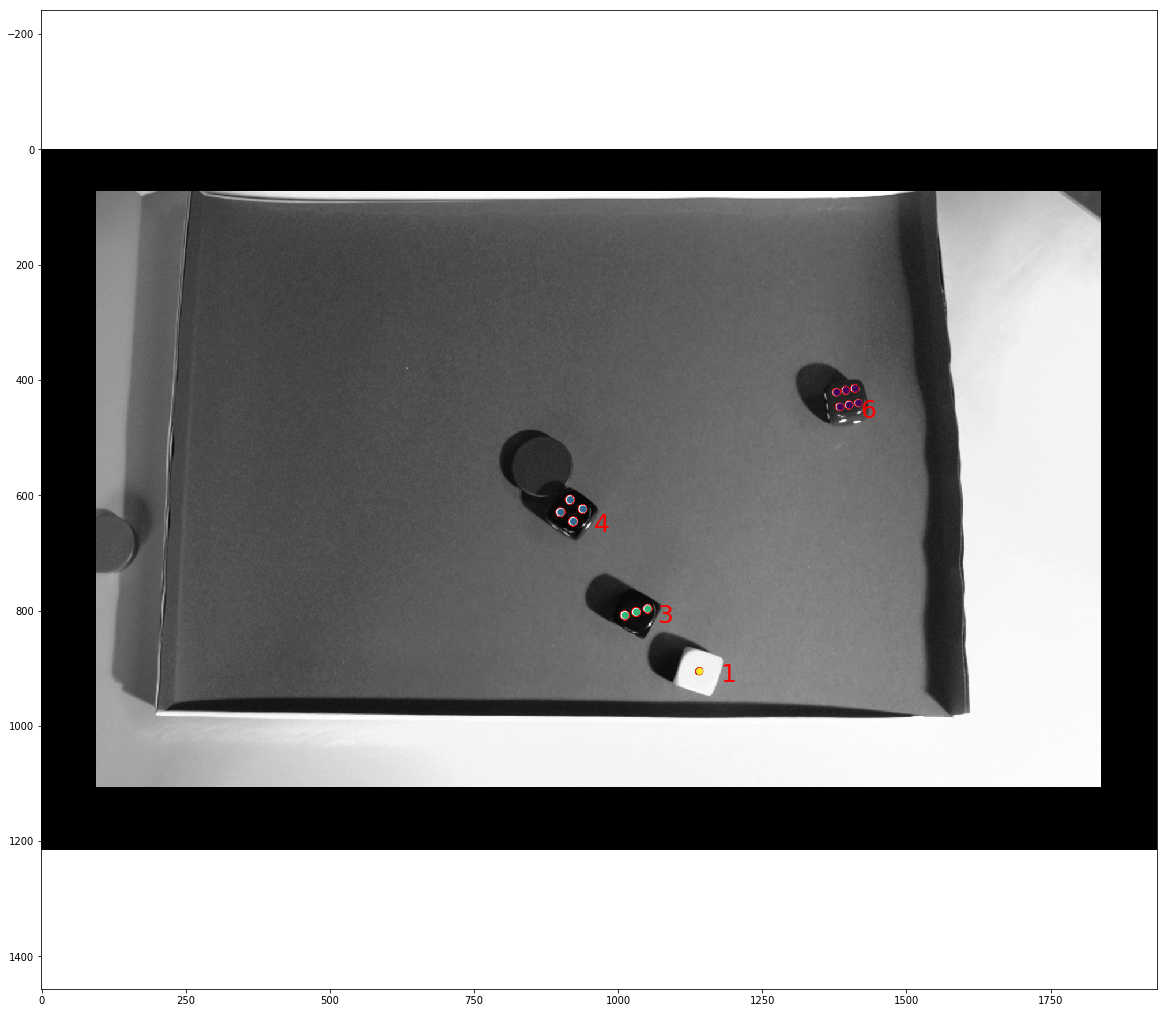

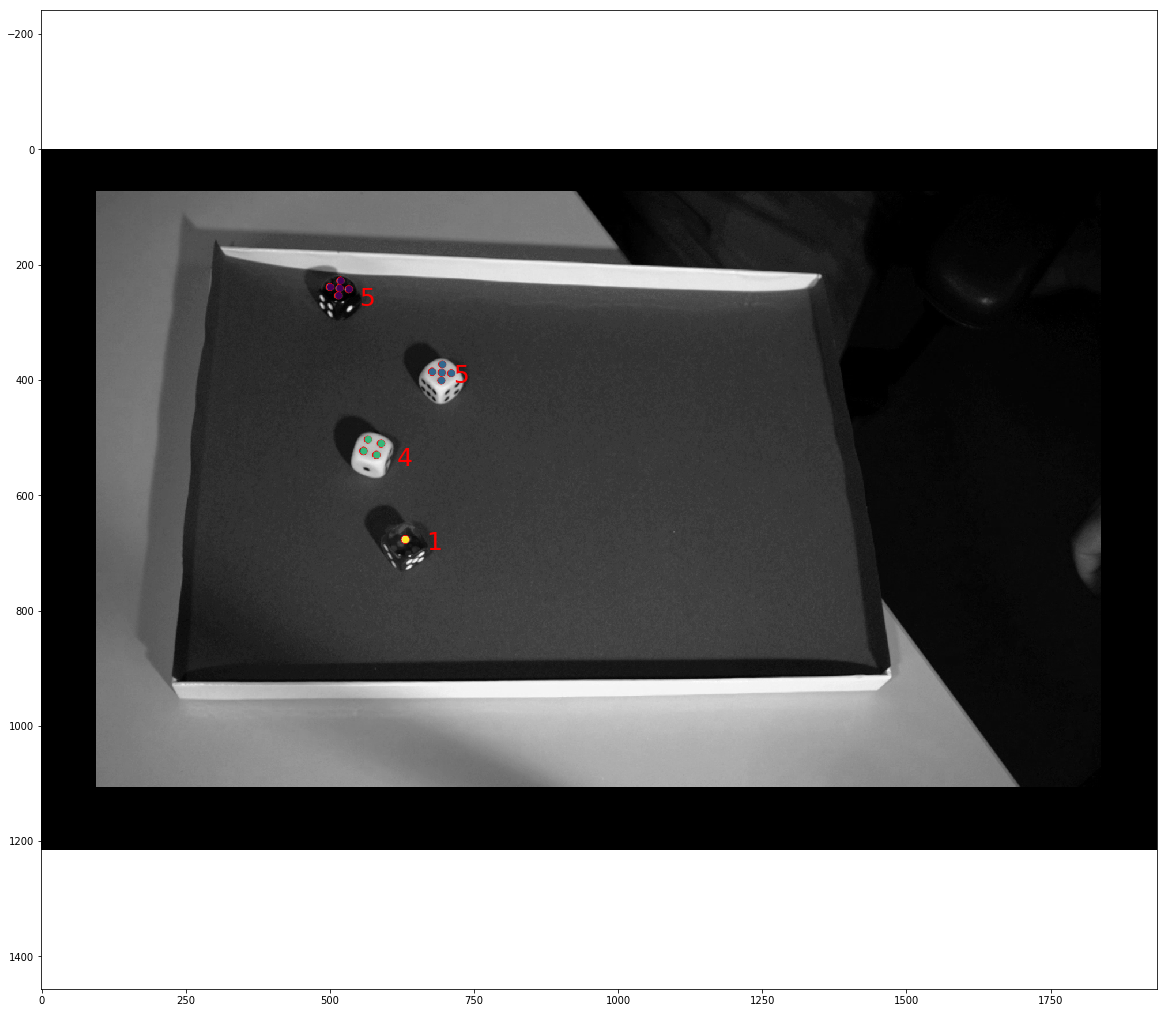

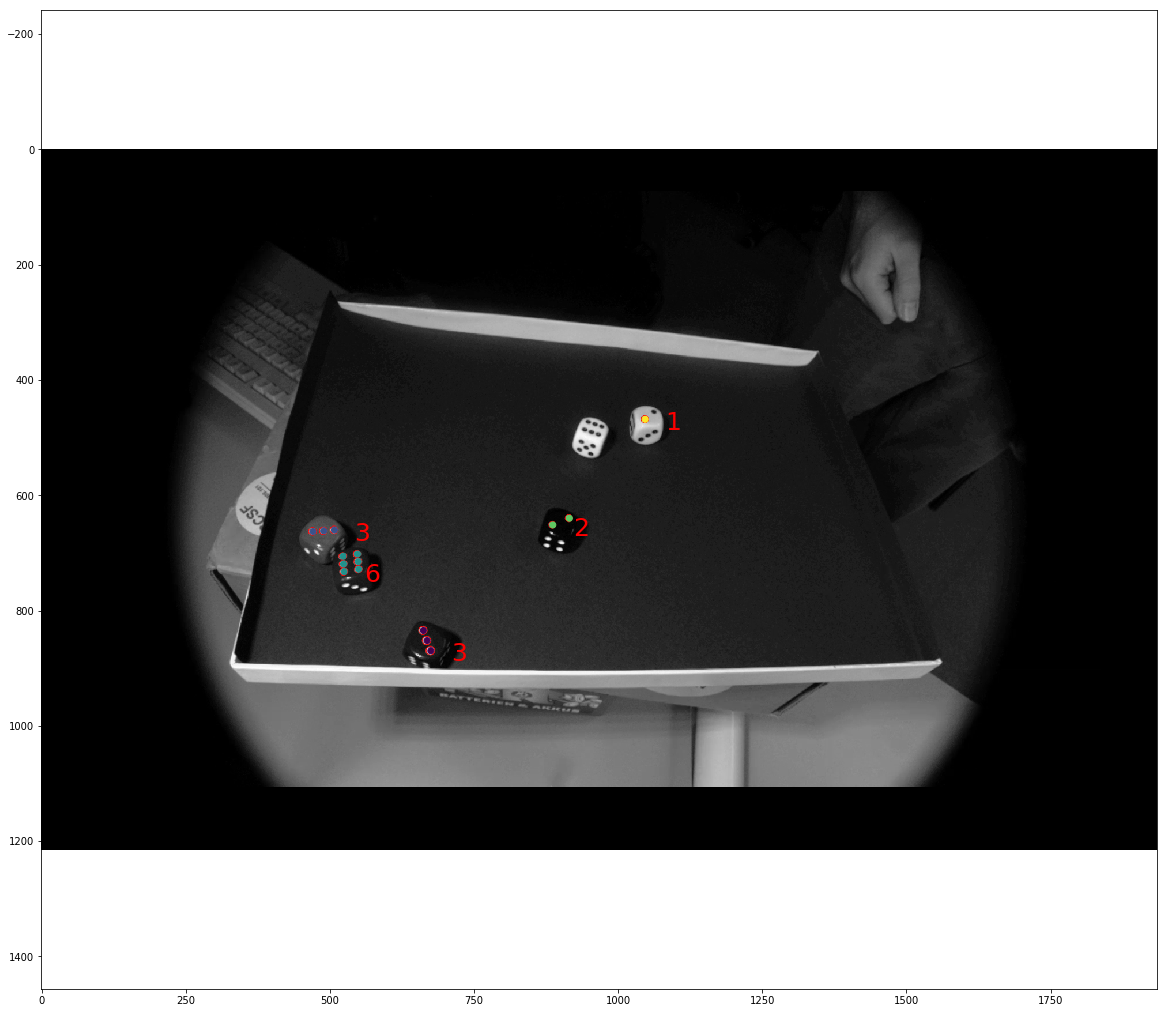

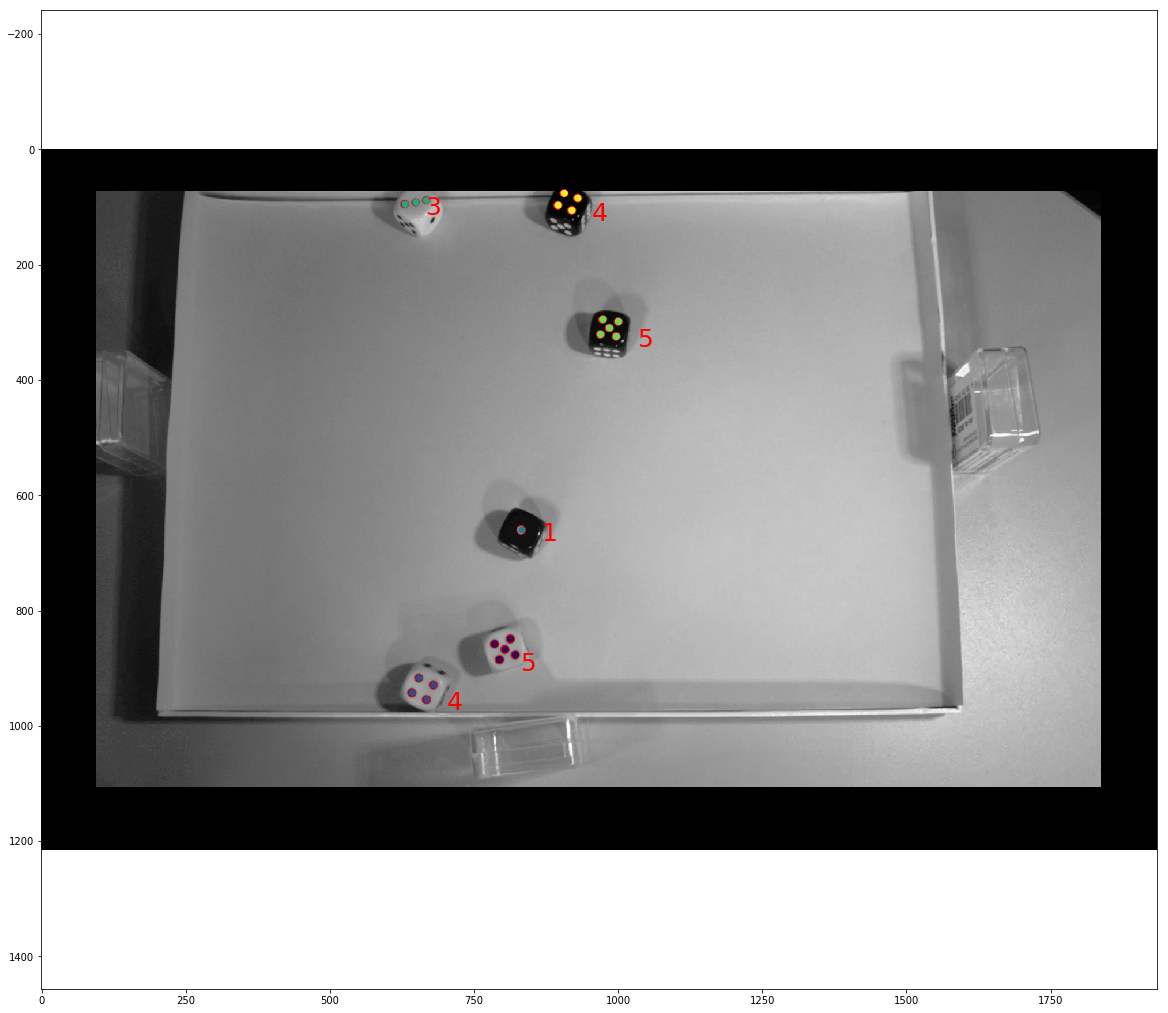

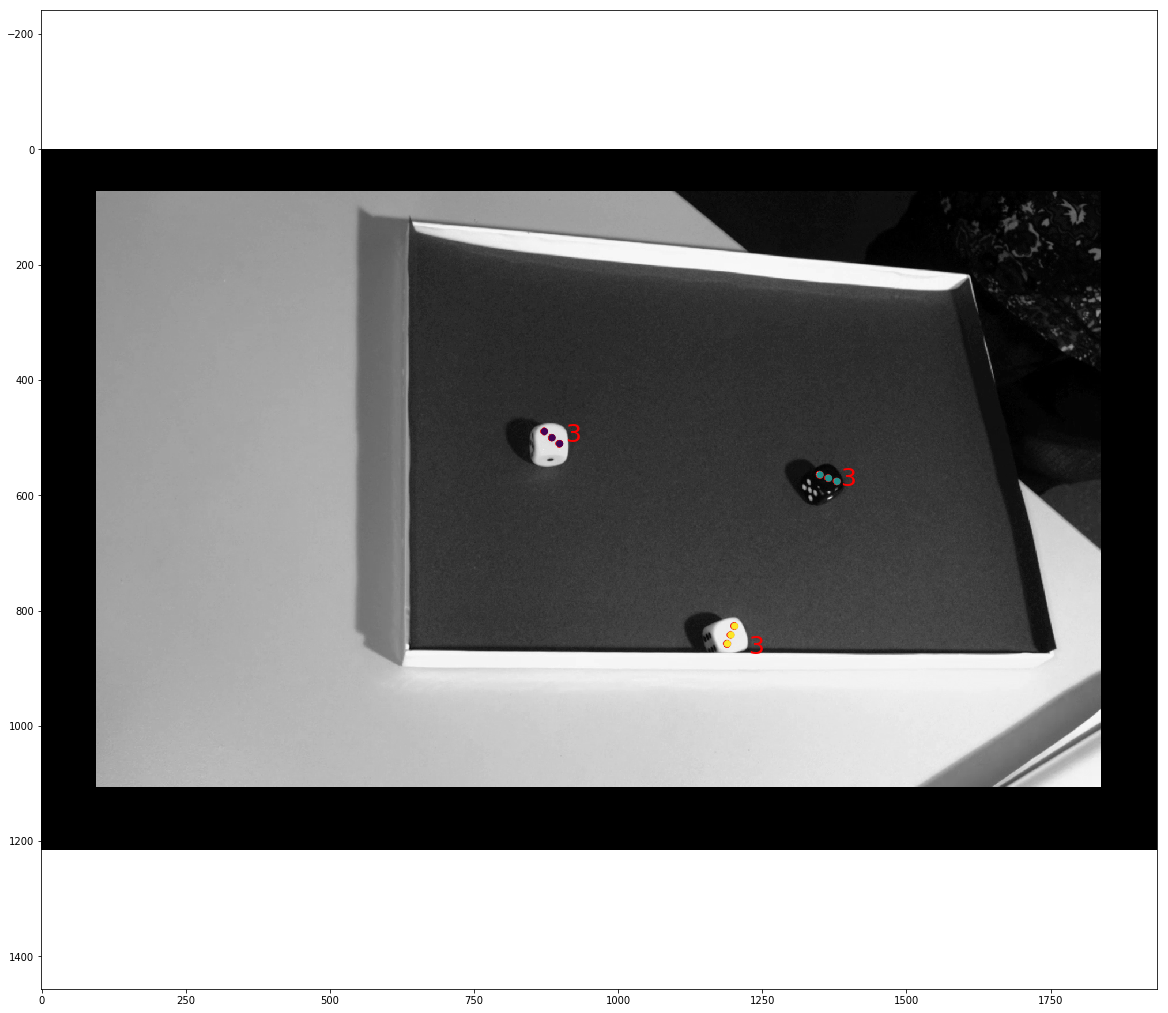

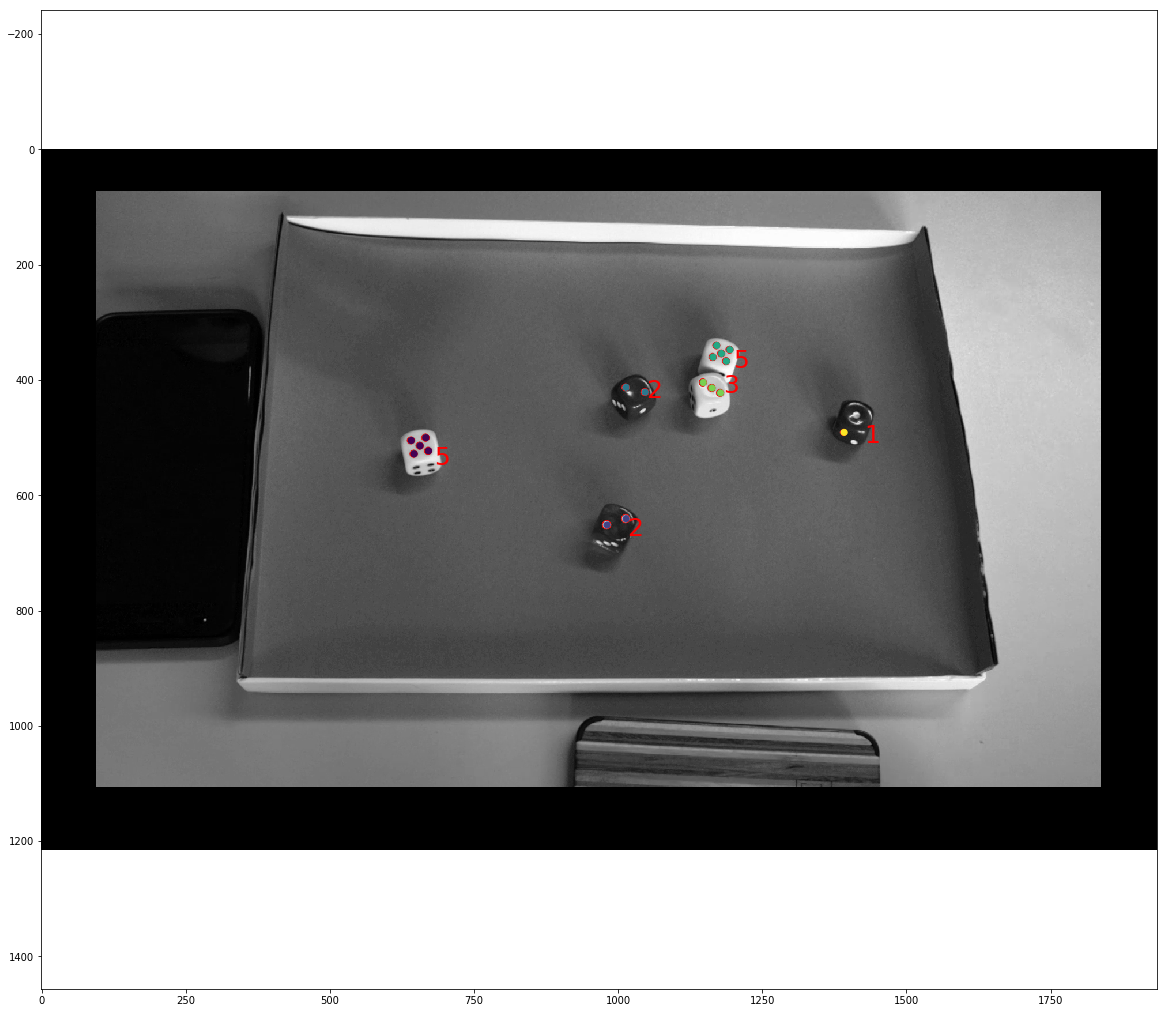

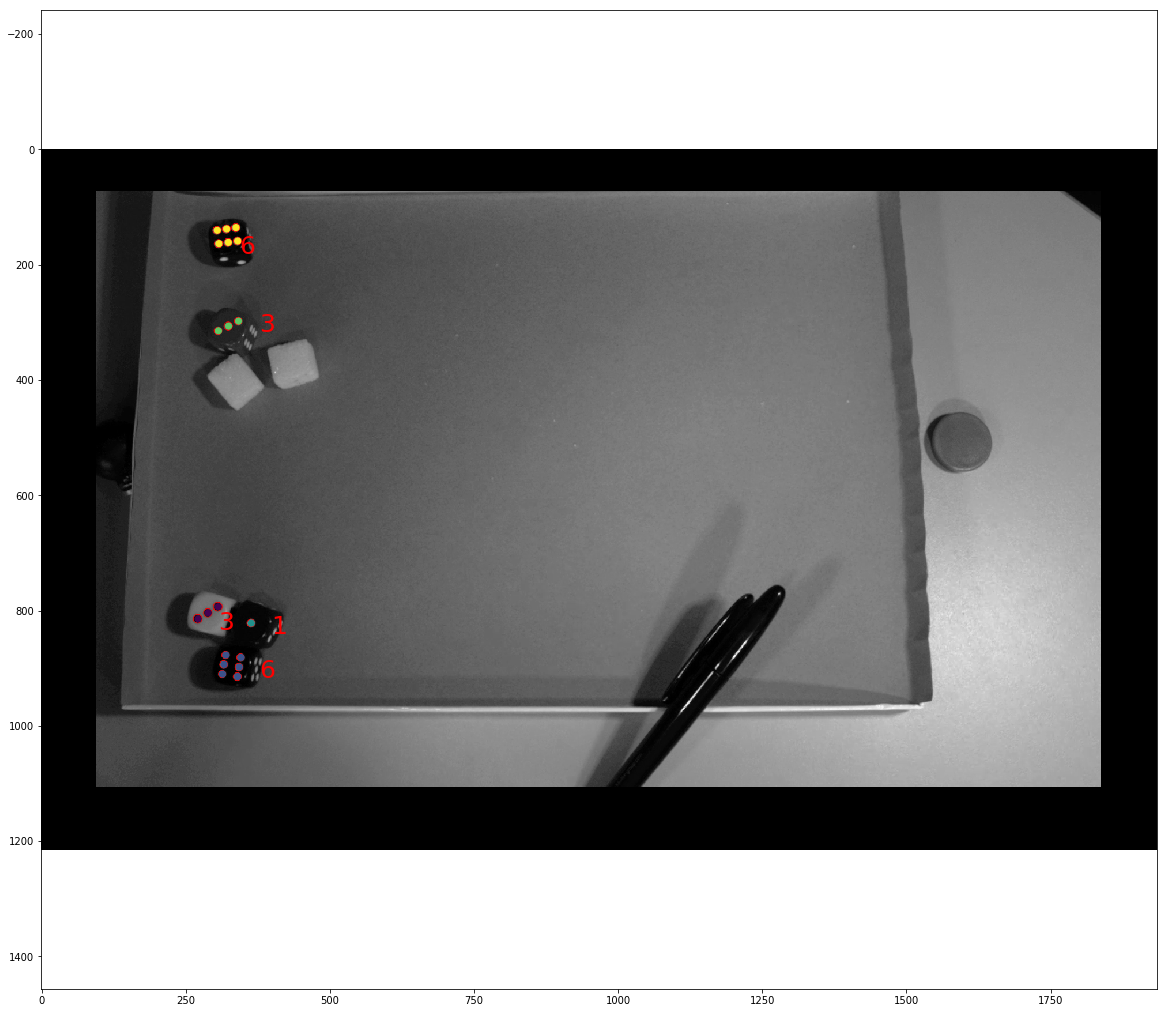

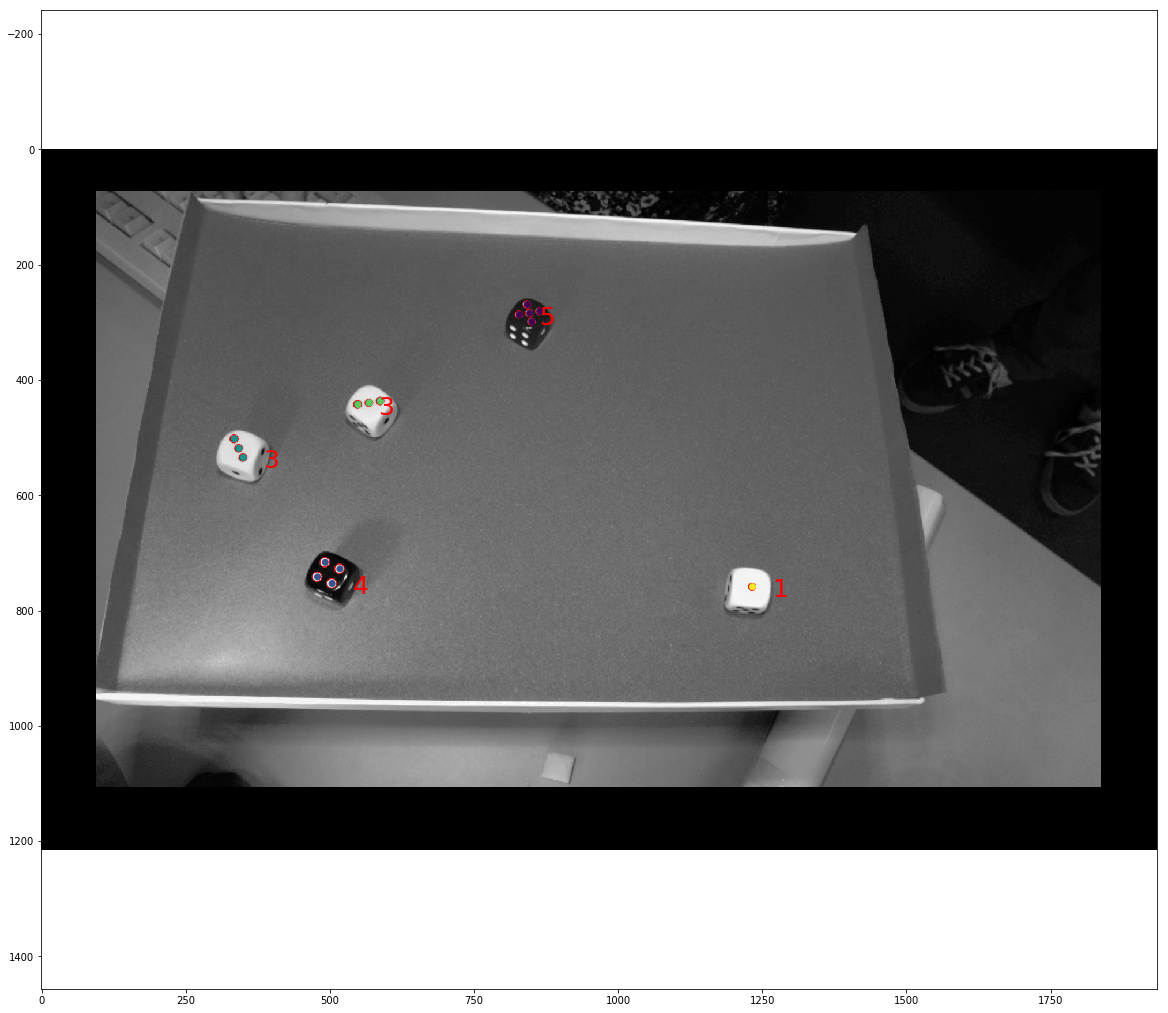

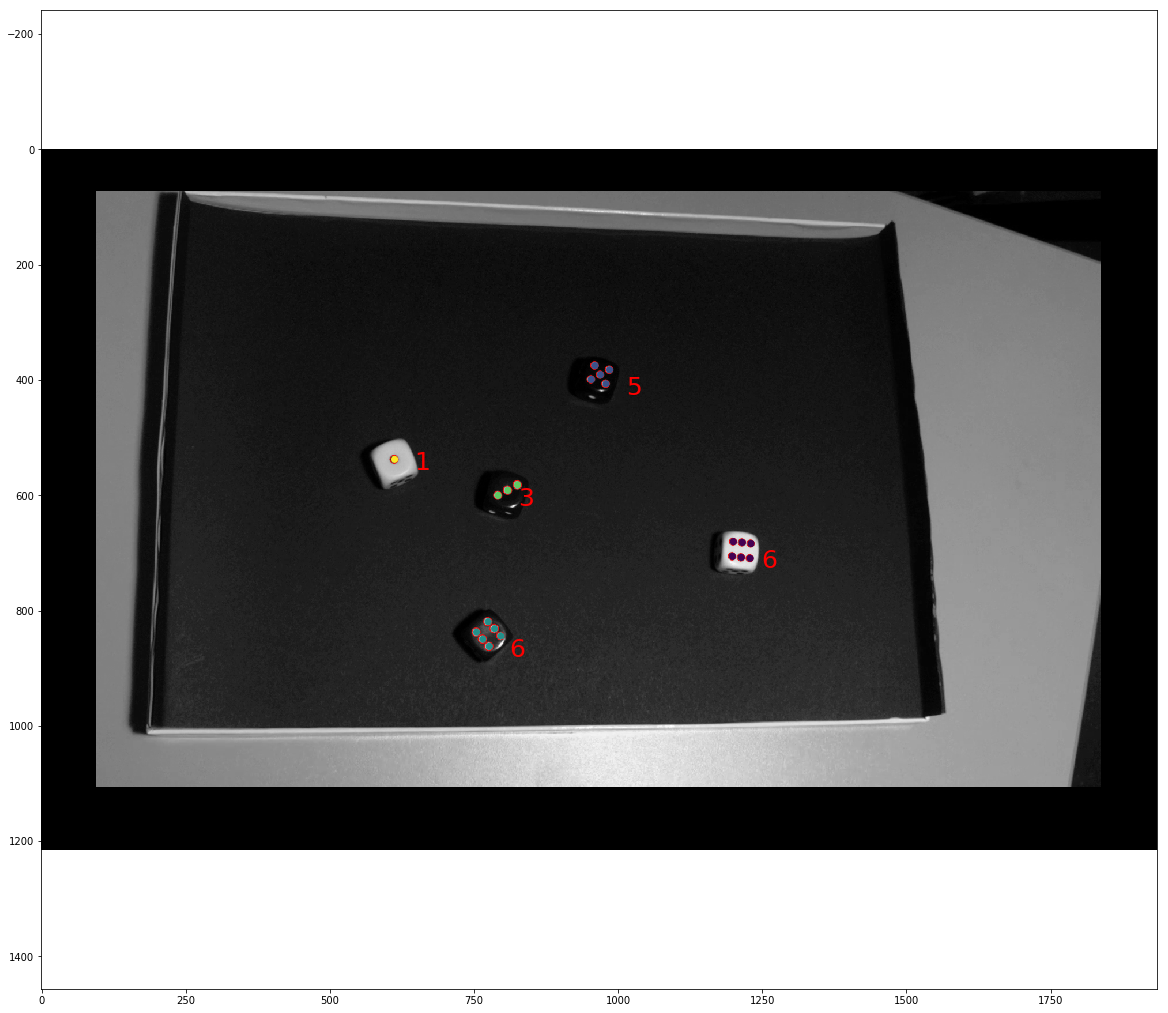

Average time taken per video:  1.16253969669 secs


In [4]:
start = time.time()

# reading in all the videos
file_list = os.listdir('./VideoPackage/')
file_list = [f for f in file_list if f.endswith(".avi")]

captured_frames = capture_frames(file_list)

detect_pips_and_locations(captured_frames)

end = time.time()
print "Average time taken per video: ", (end-start)/20, "secs"